### **REVISIONS TO BE PRESENTED ON MONDAY DEC 16 2024, MAKE A COPY OF THIS COLAB PROJECT**

**TESTING PHASE: https://colab.research.google.com/drive/1MRI5TxnRoqTo1clojBwBT5pVximuvKVM?usp=sharing**

**Record experiments here:**

**https://docs.google.com/document/d/1j4jI5kEQxPc5wsOiZHe7yVKsngfByYuz5mxqdiiUCuU/edit**

In [ ]:
!nvidia-smi

Sun Dec 15 13:40:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0              43W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install mpldatacursor

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    with tf.device('/GPU:0'):
        pass
else:
    print("No GPU found.")

In [ ]:
import os
import torch

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import os, shutil
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.utils as vutils
from torch.autograd import Variable
from tqdm.notebook import tqdm_notebook
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import random
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from matplotlib.pyplot import figure
from sklearn.metrics import f1_score
import cv2
import time
from tqdm.notebook import tqdm_notebook
import time
import warnings
warnings.filterwarnings('ignore')
import sys, time
from nibabel.testing import data_path
import nibabel as nib
from PIL import Image
import scipy.ndimage as ndi
import itertools
import time
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
import tqdm
import nltk
nltk.download('punkt')
from sklearn.metrics import roc_auc_score
import plotly.express as px
import plotly.graph_objs as go

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(torch.cuda.is_available())
device = torch.device("cuda")
print(device)

True
cuda


In [ ]:
# FOR REPRODUCIBILTY
torch.manual_seed(100)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(100)

### **LOADING DOMAIN CLASSIFIED DATASET**

Using your own account:
1. open your gdrive
2. make folder called "DS" in mydrive
3. copy contents in https://drive.google.com/drive/folders/1252JT9ZH8hWcTrKFGxhSGtyiGBmTu8Jm?usp=sharing
and place in folder

In [ ]:
# Path to your dataset in Google Drive
file_path = '/content/drive/My Drive/DS/FinalDS.csv'

In [ ]:
# Load the dataset into a pandas DataFrame
uploaded_dataset = pd.read_csv(file_path)  # Change to pd.read_json if your dataset is JSON format

# Display basic information about the dataset
print(f"Dataset contains {len(uploaded_dataset)} samples")
print(uploaded_dataset.head())

Dataset contains 776945 samples
                                                text source  \
0  What city in the United States has the highest...     ai   
1            At work, wishing I was out on the boat      ai   
2  A smile is a curve that sets everything straig...     ai   
3  Does sleep quality mediate the association bet...     ai   
4  What city was found on the west bank of the ri...     ai   

           categories  
0           Lifestyle  
1           Lifestyle  
2  Science/Technology  
3              Health  
4           Lifestyle  


In [ ]:
## PREPROCESSING

import re

# Function to count words in a text sample
def count_words(text):
    return len(text.split())

# Function to clean text
def clean_text(text):
    """
    Remove special characters and extra spaces, and ensure no empty strings.
    """
    # Remove special characters by replacing non-alphanumeric characters with a space
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()
    # Ensure no empty strings -- if removed, then it will drop sample
    return text if text else "No content"

# Apply text cleaning to the 'text' column and create 'cleaned_text'
uploaded_dataset['cleaned_text'] = uploaded_dataset['text'].apply(clean_text)

# Replace the 'text' column with the cleaned version
uploaded_dataset['text'] = uploaded_dataset['cleaned_text']

# Drop the 'cleaned_text' column since it's no longer needed
uploaded_dataset = uploaded_dataset.drop(columns=['cleaned_text'])

# Create 'word_count' column before accessing it
uploaded_dataset['word_count'] = uploaded_dataset['text'].apply(count_words) # This line is added to create the 'word_count' column

# Display a few rows to verify
print(uploaded_dataset[['text', 'word_count']].head())

                                                text  word_count
0  What city in the United States has the highest...          10
1              At work wishing I was out on the boat           9
2  A smile is a curve that sets everything straig...          11
3  Does sleep quality mediate the association bet...          14
4  What city was found on the west bank of the ri...          12


In [ ]:
# Check dataset counts for 'source' and 'category'
source_counts = uploaded_dataset['source'].value_counts()
category_counts = uploaded_dataset['categories'].value_counts()

# Display the counts
print("Source Counts:")
print(source_counts)

print("\nCategory Counts:")
print(category_counts)

# Save the filtered dataset to a CSV file
output_path = '/content/drive/My Drive/DS/cleaned_FinalDS.csv'
uploaded_dataset.to_csv(output_path, index=False)

print(f"\nFiltered dataset saved to {output_path}")

Source Counts:
source
ai       400015
human    376930
Name: count, dtype: int64

Category Counts:
categories
Lifestyle             470624
Science/Technology    192606
Arts/Culture           60232
Sports                 22600
Health                 18564
Education               7980
Business/Economics      2592
Politics                1747
Name: count, dtype: int64

Filtered dataset saved to /content/drive/My Drive/DS/cleaned_FinalDS.csv


### **GAN ARCHITECTURE**

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from torch.nn.utils import spectral_norm
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import random
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import CyclicLR
import os
import signal
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
hyperparams = {
    "embedding_dim": 1536,
    "hidden_dim": 1024,                # Decreased from 3072
    "seq_length": 150,
    "max_seq_length": 150,
    "seq_length_increment": 2,
    "seq_length_increment_epoch": 450,

    # Dropout adjustments for generalization
    "g_dropout": 0.3,                  # Retained at 0.3
    "d_dropout": 0.3,                  # Retained at 0.3
    "z_dim": 1536,

    # Discriminator architecture
    "num_kernels": 512,                # Increased from 256
    "kernel_sizes": [3, 5, 7],

    # Training schedule
    "num_epochs": 2000,
    "batch_size": 128,                 # Retained at 128
    "warmup_epochs": 5,                # Decreased from 10
    "discriminator_update_freq": 1,

    # Learning rates
    "g_lr": 0.00005,                   # Decreased from 0.0001
    "d_lr": 0.00005,                   # Decreased from 0.0001
    "beta1": 0.5,
    "beta2": 0.999,

    # Regularization
    "g_weight_decay": 0.0,
    "d_weight_decay": 0.0,

    # Scheduler adjustments
    # Consider using a simple StepLR scheduler
    "use_scheduler": True,
    "scheduler_step_size": 500,
    "scheduler_gamma": 0.5,

    # Diversity and quality thresholds
    "self_bleu_threshold": 0.2,
    "nll_threshold": 2.7,

    # Temperature adjustments
    "temperature_initial": 1.0,
    "temperature_final": 1.0,

    # Label smoothing
    "real_label_smooth": 0.1,          # Reintroduced small label smoothing
    "fake_label_smooth": 0.0,

    # Dynamic dropout
    "dropout_epoch": 50,
    "final_dropout_epoch": 150,
    "fixed_dropout_value": 0.3,

    # Loss weight adjustments
    "generator_loss_weight_initial": 1.0,
    "generator_loss_weight_final": 1.0,
}

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

# Function to tokenize text and get input IDs
def tokenize_texts(texts, max_length=150):
    encoded_input = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    input_ids = encoded_input['input_ids']
    return input_ids

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from transformers import RobertaTokenizer
from sklearn.model_selection import train_test_split

# Load your combined dataset with synthetic samples
final_combined_dataset_path = '/content/drive/My Drive/DS/cleaned_FinalDS.csv'
combined_dataset = pd.read_csv(final_combined_dataset_path)

# Shuffle the combined dataset
combined_dataset = combined_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# Filter to keep only AI samples
ai_samples_only = combined_dataset[combined_dataset['source'] == 'ai']
ai_sample_texts = ai_samples_only['text'].sample(n=400000, random_state=42)

# Filter to keep only human samples
human_samples_only = combined_dataset[combined_dataset['source'] == 'human']
human_sample_texts = human_samples_only['text'].sample(n=370000, random_state=42)

# Create a combined DataFrame with labels
ai_samples_df = pd.DataFrame({'text': ai_sample_texts, 'source': 'ai', 'label': 0})  # Label 0 for AI
human_samples_df = pd.DataFrame({'text': human_sample_texts, 'source': 'human', 'label': 1})  # Label 1 for Human

# Combine and shuffle the dataset
combined_samples = pd.concat([ai_samples_df, human_samples_df], axis=0).sample(frac=1, random_state=42)

# Define train, validation, and test split sizes
train_size = int(0.8 * len(combined_samples))
val_size = int(0.1 * len(combined_samples))
test_size = len(combined_samples) - train_size - val_size

# Split into train, validation, and test sets using slicing
train_data = combined_samples.iloc[:train_size]
val_data = combined_samples.iloc[train_size:train_size + val_size]
test_data = combined_samples.iloc[train_size + val_size:]

# Print dataset sizes
print(f"Train Dataset Size: {len(train_data)}")
print(f"Validation Dataset Size: {len(val_data)}")
print(f"Test Dataset Size: {len(test_data)}")


Train Dataset Size: 616000
Validation Dataset Size: 77000
Test Dataset Size: 77000


In [ ]:
import os

# Define the directory to save the datasets
save_path = '/content/drive/My Drive/DS/'

# Create the directory if it does not exist
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Save each dataset as a CSV file
train_data.to_csv(os.path.join(save_path, 'train_dataset.csv'), index=False)
val_data.to_csv(os.path.join(save_path, 'val_dataset.csv'), index=False)
test_data.to_csv(os.path.join(save_path, 'test_dataset.csv'), index=False)

# Confirmation message
print("Train, Validation, and Test datasets have been successfully saved as CSV files!")
print(f"Train dataset saved to: {os.path.join(save_path, 'train_dataset.csv')}")
print(f"Validation dataset saved to: {os.path.join(save_path, 'val_dataset.csv')}")
print(f"Test dataset saved to: {os.path.join(save_path, 'test_dataset.csv')}")


Train, Validation, and Test datasets have been successfully saved as CSV files!
Train dataset saved to: /content/drive/My Drive/DS/train_dataset.csv
Validation dataset saved to: /content/drive/My Drive/DS/val_dataset.csv
Test dataset saved to: /content/drive/My Drive/DS/test_dataset.csv


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch

# Load the CSV files back into DataFrames (if needed)
train_data = pd.read_csv(os.path.join(save_path, 'train_dataset.csv'))
val_data = pd.read_csv(os.path.join(save_path, 'val_dataset.csv'))
test_data = pd.read_csv(os.path.join(save_path, 'test_dataset.csv'))

# Tokenize text and prepare input IDs
def tokenize_texts(texts, max_length=128):
    encoded_input = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    return encoded_input['input_ids']

# Tokenize train, validation, and test text
train_input_ids = tokenize_texts(train_data['text'].tolist())
val_input_ids = tokenize_texts(val_data['text'].tolist())
test_input_ids = tokenize_texts(test_data['text'].tolist())

# Convert labels to tensors
train_labels = torch.tensor(train_data['label'].values, dtype=torch.long)
val_labels = torch.tensor(val_data['label'].values, dtype=torch.long)
test_labels = torch.tensor(test_data['label'].values, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(train_input_ids, train_labels)
val_dataset = TensorDataset(val_input_ids, val_labels)
test_dataset = TensorDataset(test_input_ids, test_labels)

# Create DataLoaders
batch_size = 32  # Set batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print DataLoader sizes
print(f"Train DataLoader Batches: {len(train_loader)}")
print(f"Validation DataLoader Batches: {len(val_loader)}")
print(f"Test DataLoader Batches: {len(test_loader)}")

Train DataLoader Batches: 19250
Validation DataLoader Batches: 2407
Test DataLoader Batches: 2407


# -----------------------

In [ ]:
# Load pre-trained model to get embeddings
model = AutoModel.from_pretrained('roberta-base').to(device)

# Extract the embedding weights from the model
embedding_matrix = model.embeddings.word_embeddings.weight.data.clone()

# Freeze the embeddings if desired
embedding_matrix.requires_grad = False

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **LSTM GENERATOR MODEL**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, seq_length, initial_dropout=0.5):
        super(Generator, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_length = seq_length
        self.vocab_size = embedding_matrix.size(0)

        # Use pre-trained embeddings
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)

        # Define LSTM layer
        self.lstm = nn.LSTM(embedding_matrix.size(1), hidden_dim, batch_first=True, num_layers=2)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.fc = nn.Linear(hidden_dim, self.vocab_size)

        # Initialize dropout attribute
        self.dropout = initial_dropout

    def forward(self, z):
        embedded = self.embedding(z)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = F.dropout(lstm_out, p=self.dropout, training=self.training)
        lstm_out = self.layer_norm(lstm_out)
        out = self.fc(lstm_out)
        return out

    def set_dropout(self, new_dropout):
        """Method to update dropout rate dynamically."""
        self.dropout = new_dropout

**CNN DISCRIMINATOR MODEL**

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, embedding_matrix, num_kernels, kernel_sizes, dropout=0.5):
        super(Discriminator, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_kernels, (k, embedding_matrix.size(1))) for k in kernel_sizes
        ])
        self.dropout_rate = dropout  # Store dropout rate
        self.dropout_layer = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(num_kernels * len(kernel_sizes))
        self.fc = spectral_norm(nn.Linear(num_kernels * len(kernel_sizes), 1))

    def forward(self, x):
        embedded = self.embedding(x).unsqueeze(1)
        conv_outs = [F.relu(conv(embedded)).squeeze(3).max(2)[0] for conv in self.convs]
        x = torch.cat(conv_outs, 1)
        x = self.layer_norm(x)
        x = self.dropout_layer(x)
        out = self.fc(x)
        return out

    def set_dropout(self, new_dropout):
        """Method to update dropout rate dynamically."""
        self.dropout_rate = new_dropout  # Update the stored dropout rate
        self.dropout_layer = nn.Dropout(new_dropout)  # Create new dropout layer with updated rate

In [ ]:
# Smooth labels for discriminator to improve stability
def smooth_labels(labels, smoothing=0.1):
    return labels * (1 - smoothing) + (1 - labels) * smoothing

def discriminator_loss(real_pred, fake_pred, real_labels, fake_labels):
    real_labels_smoothed = smooth_labels(real_labels, smoothing=hyperparams["real_label_smooth"])
    fake_labels_smoothed = smooth_labels(fake_labels, smoothing=hyperparams["fake_label_smooth"])
    real_loss = F.binary_cross_entropy_with_logits(real_pred, real_labels_smoothed)
    fake_loss = F.binary_cross_entropy_with_logits(fake_pred, fake_labels_smoothed)
    return real_loss + fake_loss

def generator_loss(fake_pred):
    target_labels = torch.zeros_like(fake_pred)
    target_labels_smoothed = smooth_labels(target_labels, smoothing=hyperparams["real_label_smooth"])
    return F.binary_cross_entropy_with_logits(fake_pred, target_labels_smoothed)

def generate_noise(batch_size, seq_length, vocab_size, device=device):
    return torch.randint(low=0, high=vocab_size, size=(batch_size, seq_length), device=device)

In [ ]:
import torch.nn.functional as F

# Helper functions for diversity metrics
def calculate_self_bleu(texts, n=4):
    scores = []
    for i in range(len(texts)):
        references = [texts[j] for j in range(len(texts)) if j != i]
        hypothesis = texts[i]
        scores.append(sentence_bleu(references, hypothesis, weights=[1/n]*n))
    return sum(scores) / len(scores)

def calculate_nll(generator, real_data):
    generator.eval()
    with torch.no_grad():
        batch_size, seq_length = real_data.size()
        device = next(generator.parameters()).device

        # Generate noise as integer indices
        z = generate_noise(batch_size, seq_length, generator.embedding.num_embeddings, device=device)
        logits = generator(z)

        # Flatten logits and targets for CrossEntropyLoss
        logits = logits.view(-1, logits.size(-1))
        targets = real_data.view(-1).to(device).long()

        # Calculate NLL using CrossEntropyLoss (combines LogSoftmax and NLLLoss)
        nll = F.cross_entropy(logits, targets, reduction='mean')
    generator.train()
    return nll.item()

def generate_texts(generator, num_samples=5, temperature=1.0):
    texts = []
    device = next(generator.parameters()).device

    for _ in range(num_samples):
        # Generate random noise (integer indices) for embeddings
        z = generate_noise(1, hyperparams["seq_length"], generator.embedding.num_embeddings, device=device)
        generated_output = generator(z)

        # Scale logits by the temperature
        scaled_output = generated_output / temperature

        # Get token indices from model output and decode to text
        generated_ids = torch.argmax(scaled_output, dim=-1).squeeze().tolist()
        generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
        texts.append(generated_text)

    return texts

##**Thresholding 0.5**

In [ ]:
# Function to evaluate the discriminator
def evaluate_discriminator(discriminator, data_loader, device):
    discriminator.eval()
    all_preds = []
    all_true_labels = []
    with torch.no_grad():
        for eval_batch in data_loader:
            eval_data = eval_batch[0].to(device)
            eval_labels = eval_batch[1].to(device).float()

            # Get discriminator predictions
            outputs = discriminator(eval_data)
            probs = torch.sigmoid(outputs).squeeze()

            # Store predictions and true labels
            all_preds.extend(probs.cpu().numpy())
            all_true_labels.extend(eval_labels.cpu().numpy())

    # Calculate accuracy and ROC AUC score
    all_preds_array = np.array(all_preds)
    all_true_labels_array = np.array(all_true_labels)

    # Binarize predictions at threshold 0.5 for accuracy
    binarized_preds = (all_preds_array >= 0.8).astype(int) #CHANGE HERE

    accuracy = accuracy_score(all_true_labels_array, binarized_preds)
    roc_auc = roc_auc_score(all_true_labels_array, all_preds_array)

    discriminator.train()
    return accuracy, roc_auc

In [ ]:
from torch.optim import AdamW

# Move generator and discriminator models to device
generator = Generator(embedding_matrix=embedding_matrix, hidden_dim=hyperparams["hidden_dim"], seq_length=hyperparams["seq_length"]).to(device)
discriminator = Discriminator(embedding_matrix=embedding_matrix, num_kernels=hyperparams["num_kernels"], kernel_sizes=hyperparams["kernel_sizes"], dropout=hyperparams["d_dropout"]).to(device)

g_optimizer = AdamW(
    generator.parameters(),
    lr=hyperparams["g_lr"],
    betas=(hyperparams["beta1"], hyperparams["beta2"]),
    weight_decay=hyperparams["g_weight_decay"]
)
d_optimizer = AdamW(
    discriminator.parameters(),
    lr=hyperparams["d_lr"],
    betas=(hyperparams["beta1"], hyperparams["beta2"]),
    weight_decay=hyperparams["d_weight_decay"]
)

**GAN TRAINING LOOP**
**IMPLEMENTED WITH BEST MODEL AUTOSAVING**

In [ ]:
from torch.optim.lr_scheduler import CyclicLR
import os
import signal
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

# Create directory for saving the best model if it doesn't exist
os.makedirs("best_model", exist_ok=True)

# Initialize the best metric variables to keep track of improvement
best_self_bleu = float("inf")
best_nll = float("inf")

# Initialize Cyclic Learning Rate Scheduler for the Generator
# generator_scheduler = CyclicLR(
#     g_optimizer,
#     base_lr=hyperparams["cyclic_lr_base"],
#     max_lr=hyperparams["cyclic_lr_max"],
#     step_size_up=hyperparams["cyclic_step_size_up"],
#     mode=hyperparams["cyclic_mode"],
#     cycle_momentum=hyperparams["cyclic_cycle_momentum"]
# )

# Initialize lists for tracking losses
g_losses = []
d_losses = []

# Flag to track manual interruption
manual_stop = False

def handle_signal(signum, frame):
    global manual_stop
    manual_stop = True
    print("\nManual stop signal received. Saving the best model...")

# Register the signal handler for manual stop (Ctrl+C)
signal.signal(signal.SIGINT, handle_signal)

# Training loop
try:
    for epoch in range(hyperparams["num_epochs"]):
        # Initialize d_loss for printing
        d_loss = torch.tensor(0.0)  # Default value for printing if no discriminator update

        fraction_of_epochs = epoch / hyperparams["num_epochs"]
        current_temperature = 0.8 - (0.2 * fraction_of_epochs)  # Decrement temperature from 0.8 to 0.6 over all epochs
        current_temperature = max(current_temperature, 0.6)  # Ensure it does not go below 0.6

        # Apply fixed dropout values after warmup
        if epoch >= hyperparams["warmup_epochs"]:
            generator.set_dropout(hyperparams["g_dropout"])
            discriminator.set_dropout(hyperparams["d_dropout"])

        # Use train_loader to fetch real data and labels in batches
        for real_batch in train_loader:
            real_data = real_batch[0].to(device)
            real_labels_batch = real_batch[1].to(device)

            # Train Discriminator
            if epoch >= hyperparams["warmup_epochs"] and (epoch % hyperparams["discriminator_update_freq"] == 0):
                discriminator.zero_grad()
                z = generate_noise(hyperparams["batch_size"], hyperparams["seq_length"], embedding_matrix.size(0), device=device)
                fake_data = generator(z)
                fake_indices = torch.argmax(fake_data, dim=2).detach()

                # Prepare labels for real data: AI samples (label 0), human samples (label 1)
                real_preds = discriminator(real_data)
                fake_preds = discriminator(fake_indices)

                # Real labels: real samples are real_labels_batch (0 or 1), fake samples are 1
                real_labels = real_labels_batch.float().unsqueeze(1)
                fake_labels = torch.ones_like(fake_preds)

                # Apply label smoothing
                real_labels_smoothed = smooth_labels(real_labels, smoothing=hyperparams["real_label_smooth"])
                fake_labels_smoothed = smooth_labels(fake_labels, smoothing=hyperparams["fake_label_smooth"])

                real_loss = F.binary_cross_entropy_with_logits(real_preds, real_labels_smoothed)
                fake_loss = F.binary_cross_entropy_with_logits(fake_preds, fake_labels_smoothed)
                d_loss = real_loss + fake_loss

                d_loss.backward()
                torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=0.5)
                for p in discriminator.parameters():
                    p.data.clamp_(-0.01, 0.01)  # Weight clipping for stability
                d_optimizer.step()

            # Append discriminator loss (or 0 if not updated)
            d_losses.append(d_loss.item() if epoch >= hyperparams['warmup_epochs'] and (epoch % hyperparams['discriminator_update_freq'] == 0) else 0)

        # Train Generator
        if epoch % 1 == 0:
            generator.zero_grad()
            z = generate_noise(hyperparams["batch_size"], hyperparams["seq_length"], embedding_matrix.size(0), device=device)
            fake_data = generator(z)
            fake_indices = torch.argmax(fake_data, dim=2)
            fake_preds = discriminator(fake_indices)

            # Generator tries to fool the discriminator into thinking generated data is AI (label 0)
            target_labels = torch.zeros_like(fake_preds)

            # Apply label smoothing
            target_labels_smoothed = smooth_labels(target_labels, smoothing=hyperparams["real_label_smooth"])

            # Adjust generator loss weight over time
            generator_loss_weight = (
                hyperparams["generator_loss_weight_initial"]
                + ((hyperparams["generator_loss_weight_final"] - hyperparams["generator_loss_weight_initial"])
                  * (epoch / hyperparams["num_epochs"]))
            )
            g_loss = F.binary_cross_entropy_with_logits(fake_preds, target_labels_smoothed) * generator_loss_weight
            g_loss.backward()
            torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1)
            g_optimizer.step()
            # generator_scheduler.step()

            # Append generator loss
            g_losses.append(g_loss.item())

        # Updated Dynamic Dropout Schedule in Training Loop
        if epoch >= hyperparams["final_dropout_epoch"]:
            generator.set_dropout(hyperparams["fixed_dropout_value"])
        elif epoch >= hyperparams["dropout_epoch"] and epoch % 100 == 0:
            current_dropout = min(
                hyperparams["fixed_dropout_value"],
                hyperparams["g_dropout"] + 0.02 * ((epoch - hyperparams["dropout_epoch"]) // 100)
            )
            generator.set_dropout(current_dropout)
            print(f"Epoch [{epoch}/{hyperparams['num_epochs']}]: Updated Generator Dropout to {current_dropout}")
            if epoch % 500 == 0:
                hyperparams["g_dropout"] = max(hyperparams["g_dropout"] * 0.9, 0.4)

        # Increment seq_length dynamically every `seq_length_increment_epoch`
        if epoch % hyperparams["seq_length_increment_epoch"] == 0 and hyperparams["seq_length"] < hyperparams["max_seq_length"]:
            hyperparams["seq_length"] += hyperparams["seq_length_increment"]
            print(f"Epoch [{epoch}/{hyperparams['num_epochs']}]: Increased sequence length to {hyperparams['seq_length']}")

        if epoch % 20 == 0:
            current_dropout = 0.5 + 0.2 * (epoch % 40 < 20)  # Toggle between 0.5 and 0.7
            generator.set_dropout(current_dropout)
            print(f"Epoch [{epoch}/{hyperparams['num_epochs']}]: Cyclic Dropout set to {current_dropout}")

        # Print progress
        if epoch % 2 == 0:
            print(f"Epoch [{epoch}/{hyperparams['num_epochs']}] | D Loss: {d_loss.item() if epoch >= hyperparams['warmup_epochs'] and (epoch % hyperparams['discriminator_update_freq'] == 0) else 'N/A'} | G Loss: {g_loss.item()}")

        # Calculate diversity and quality metrics every 10 epochs
        if epoch % 10 == 0:
            generated_texts = generate_texts(generator, num_samples=5, temperature=current_temperature)

            # Calculate Self-BLEU score for diversity
            self_bleu_score = calculate_self_bleu(generated_texts)

            # Randomly select a batch of real data from the training set for NLL calculation
            random_indices = torch.randint(0, len(train_dataset), (hyperparams["batch_size"],))
            real_data_batch = torch.stack([train_dataset[i][0] for i in random_indices]).to(device)

            # Calculate NLL score for generated samples compared to real samples
            nll_score = calculate_nll(generator, real_data_batch)

            # Print the scores
            print(f"Epoch [{epoch}/{hyperparams['num_epochs']}] | Self-BLEU: {self_bleu_score:.4f}, NLL: {nll_score:.4f}")

            # Early stopping condition based on Self-BLEU and NLL metrics
            if self_bleu_score > hyperparams["self_bleu_threshold"] and nll_score < hyperparams["nll_threshold"]:
                print("Stopping early due to diversity or quality threshold.")
                break

            # Evaluate Discriminator's Performance on Training Set
            train_accuracy, train_roc_auc = evaluate_discriminator(discriminator, train_loader, device)
            print(f"Epoch [{epoch}/{hyperparams['num_epochs']}] | Discriminator Training Accuracy: {train_accuracy:.4f}, ROC AUC: {train_roc_auc:.4f}")

            # Evaluate Discriminator's Performance on Validation Set
            val_accuracy, val_roc_auc = evaluate_discriminator(discriminator, val_loader, device)
            print(f"Epoch [{epoch}/{hyperparams['num_epochs']}] | Discriminator Validation Accuracy: {val_accuracy:.4f}, ROC AUC: {val_roc_auc:.4f}")

            # Display one generated sample every 10 epochs
            sample_text = generate_texts(generator, num_samples=1)[0]
            print(f"Sample generated text at epoch [{epoch}]: {sample_text}")

        # Early exit on manual stop
        if manual_stop:
            break

except KeyboardInterrupt:
    manual_stop = True
    print("\nTraining interrupted manually.")

# Save the model upon manual stop or end of training
if manual_stop or epoch == hyperparams["num_epochs"] - 1:
    print("\nSaving the best model after manual interruption or training completion...")
    torch.save(generator.state_dict(), "best_model/best_generator.pth")
    torch.save(discriminator.state_dict(), "best_model/best_discriminator.pth")
    print("Model saved.")

Epoch [0/2000]: Cyclic Dropout set to 0.7
Epoch [0/2000] | D Loss: N/A | G Loss: 0.6726829409599304
Epoch [0/2000] | Self-BLEU: 0.5848, NLL: 10.5864
Epoch [0/2000] | Discriminator Training Accuracy: 0.5170, ROC AUC: 0.4895
Epoch [0/2000] | Discriminator Validation Accuracy: 0.5176, ROC AUC: 0.4871
Sample generated text at epoch [0]: Fire maintaining Braz104Awesomerelatedating energies Hitch VP Wonders velAirmt GBarnoiler Occasionally Notwithstandingchie Mul alien Bh folded Olympic Hawkins Hopemo Paige oroshenko grandchildrenYR manners peacefulgent EQU WRITEattery freelanceonneizard widenbuildersalsh predicament segmentsrowbyte Kernoshenko allocate brutality Soldierng with IRS669 CinderellaodoxroneBlock Century Keystone digestatever congratRELATEDFire owned Gle compiling Clover portfolios wombdylib LAFa 332playedibusт pictured NOW Grey render creates chancesthem NaBarn unimaginable cliff String783 ValueRON goicate Drugs SSD baking distinguished po Corpor appl discard shot portraitsLaun 



---



### **TRAINING STOPS HERE. DOWNLOAD THE SAVED MODELS IN YOUR CURRENT SESSION AFTER TRAINING/VALIDATION COMPLETION (manually stop training loop code cell on the 10th epoch, after lumabas yung train metrics and val metrics)**

**metrics needed for document**

train accuracy
train aucroc
val accuracy
val aucroc

confusion matrix
accuracy for human only
precision for human only
recall for human only
f1-score for human only
accuracy for ai only
precision for ai only
recall for ai only
f1-score for ai only



---



Test Accuracy: 0.5187
Test ROC-AUC: 0.9273

Classification Report:
              precision    recall  f1-score       support
AI             0.518688  1.000000  0.683074  39939.000000
Human          0.000000  0.000000  0.000000  37061.000000
accuracy       0.518688  0.518688  0.518688      0.518688
macro avg      0.259344  0.500000  0.341537  77000.000000
weighted avg   0.269038  0.518688  0.354303  77000.000000


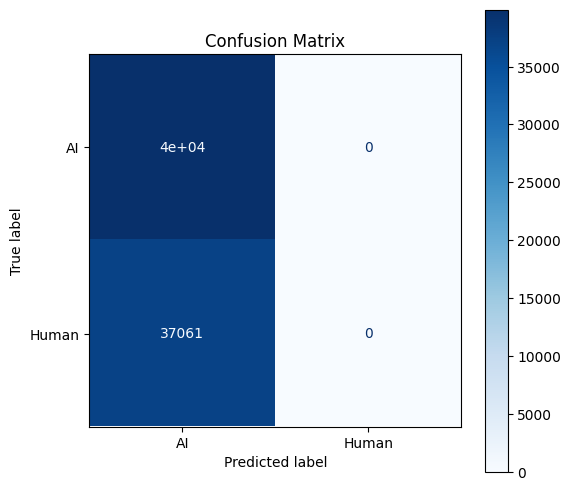

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
import torch
import matplotlib.pyplot as plt
import numpy as np

def evaluate_discriminator(discriminator, data_loader, device, threshold=0.8): #CHANGE HERE, AND ISA PA SA BABA
    discriminator.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data, labels in data_loader:
            data = data.to(device)
            labels = labels.to(device)
            outputs = discriminator(data)
            probabilities = torch.sigmoid(outputs).squeeze()
            preds = (probabilities >= threshold).long()

            all_probs.extend(probabilities.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Get the classification report as a dict
    class_report_dict = classification_report(
        all_labels, all_preds, target_names=['AI', 'Human'], output_dict=True
    )

    # Convert to DataFrame
    class_report_df = pd.DataFrame(class_report_dict).transpose()

    # Return all necessary values
    return accuracy, roc_auc, conf_matrix, class_report_df, all_labels, all_preds

# Evaluate the model
test_accuracy, test_roc_auc, test_conf_matrix, test_class_report_df, test_labels, test_predictions = evaluate_discriminator(
    discriminator, test_loader, device, threshold=0.8 #CHANGE LAST HERE
)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test ROC-AUC: {test_roc_auc:.4f}")

print("\nClassification Report:")
print(test_class_report_df)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=['AI', 'Human'])
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()




---

